In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
# create engine to hawaii.sqlite
db = "sqlite:///Resources/hawaii.sqlite"
engine = create_engine(db)

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
engine.execute('SELECT MAX(date) FROM Measurement').fetchall()

[('2017-08-23',)]

In [12]:
engine.execute('SELECT MIN(date) FROM Measurement').fetchall()

[('2010-01-01',)]

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
selection = [Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs]
data = session.query(*selection).order_by(Measurement.date.desc()).first()
# Calculate the date one year from the last date in data set.
year = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp). filter(Measurement.date >= year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(precipitation, columns = ["Date", "Precipitation"])
prcp_df = prcp_df.set_index("Date")

# Sort the dataframe by date
prcp_df = prcp_df.sort_values("Date", ascending=True)

#clean up NaN
prcp_df.dropna(how="any", inplace=True)

prcp_df



,Precipitation
Date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


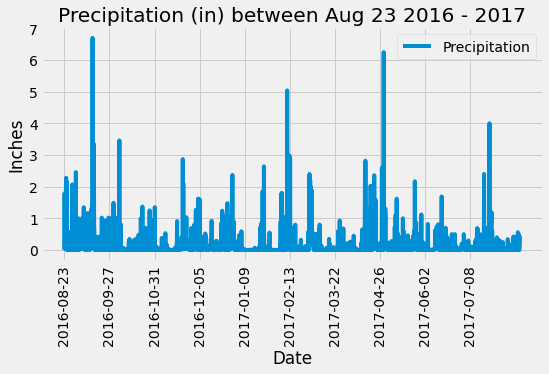

In [31]:
# Use Pandas Plotting with Matplotlib to plot the data
major_tick = np.arange(0,2000,200)
prcp_df.plot(label="Precipitation", ylabel="Inches", xticks=major_tick, use_index=True, figsize=(8,4))
plt.legend()
plt.xticks(rotation=90)
plt.title("Precipitation (in) between Aug 23 2016 - 2017")
plt.show()

In [40]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_group = prcp_df.groupby("Date")

prcp_mean= prcp_group["Precipitation"].mean()
prcp_median= prcp_group["Precipitation"].median()
prcp_var= prcp_group["Precipitation"].var()
prcp_std= prcp_group["Precipitation"].std()
prcp_sem= prcp_group["Precipitation"].sem()
        
prcp_summary = pd.DataFrame({"mean": prcp_mean, "median": prcp_median, "variance": prcp_var, 
                             "std dev": prcp_std, "SEM": prcp_sem})

prcp_summary

,mean,median,variance,std dev,SEM
Date,,,,,
2016-08-23,0.451667,0.100,0.499097,0.706468,0.288414
2016-08-24,1.555000,1.800,0.706510,0.840541,0.343150
2016-08-25,0.077143,0.080,0.005157,0.071813,0.027143
2016-08-26,0.016667,0.015,0.000267,0.016330,0.006667
2016-08-27,0.064000,0.020,0.006680,0.081731,0.036551
...,...,...,...,...,...
2017-08-19,0.030000,0.000,0.002700,0.051962,0.030000
2017-08-20,0.005000,0.005,0.000050,0.007071,0.005000
2017-08-21,0.193333,0.020,0.100933,0.317700,0.183424


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
station_ct = session.query(Station.id).count()
print(f'station count: {station_ct}')

station count: 9


In [42]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).\
order_by(func.count(Measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [47]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lo = session.query(func.min(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
hi = session.query(func.max(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()

print(f'high temp: {hi[0][0]}')
print(f'low temp: {lo[0][0]}')
print(f'avg temp: {avg[0][0]}')

high temp: 85.0
low temp: 54.0
avg temp: 71.66378066378067


In [53]:
tobs_desc = session.query(Measurement.date).filter(Measurement.station =="USC00519281").\
    order_by(Measurement.date.desc()).first() 

# result of above query ('2017-08-18',)

# find the year range

q_range = dt.date(2017, 8, 18) - dt.timedelta(days = 365)

# result of above datetime.date(2016, 8, 18)

# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
selection2 = [Measurement.date, Measurement.tobs]
tobs = session.query(*selection2).filter(Measurement.station =="USC00519281").filter(Measurement.date >= q_range).all()

tobs_df = pd.DataFrame(tobs, columns = ["Date", "Temperature"])
tobs_df = tobs_df.set_index("Date")

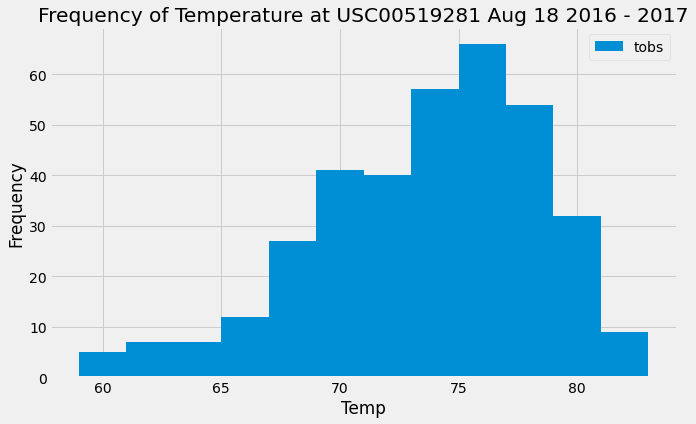

In [55]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.figure(figsize=(10,6))
plt.hist(x=tobs_df["Temperature"], bins=12, label="tobs")
plt.title("Frequency of Temperature at USC00519281 Aug 18 2016 - 2017")
plt.xlabel("Temp")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Close session

In [56]:
# Close Session
session.close()